In [2]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import urllib.request
import json
import folium

In [4]:
# load data
data = pd.read_csv('data/convert_MCMF_ALL_TIME_DATA.csv', sep="\t")
data.head()
# len(data): 84878

/var/folders/4m/9pclm3z145q989bp0z7zcgnh0000gn/T/ipykernel_26064/857982338.py:2: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/convert_MCMF_ALL_TIME_DATA.csv', sep="\t")


,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Contact Email,Contact Phone,Program Price,Geographic Cluster Name,Program Pays Participants,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food
0,"4,568",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Academic Support,2000.0,7,15,...,recruitment@bbbschgo.org,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
1,"4,569",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Work + Career,2000.0,7,15,...,recruitment@bbbschgo.org,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
2,"4,562",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Academic Support,100.0,12,18,...,wchatman@ymenchicago.com,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
3,"4,563",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Music & Art.,100.0,12,18,...,wchatman@ymenchicago.com,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
4,"4,557",78746,https://cityoflearning-uploads.s3.amazonaws.co...,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,Managing Money.,15.0,16,24,...,NaN,NaN,Free,NaN,Not Paid,YES,YES,NaN,NaN,False


In [5]:
# get rid of some columns we may not need (for now)
clean_data = data[data['Max Age'] <= 25]

# len(clean_data): 54109

cols_to_drop = ['Logo Url', 'Contact Phone', 'Program Provides Free Food', 'Program Pays Participants', 
                'Program Has Scholarships', 'Mon Start Time', 'Mon End Time', 'Tues Start Time', 'Tues End Time', 
                'Wed End Time', 'Wed Start Time', 'Thurs Start Time', 'Thurs End Time', 'Fri Start Time', 'Fri End Time', 
                'Sat Start Time', 'Sat End Time', 'Sun Start Time', 'Sun End Time', 'Scheduled Sun', 'Scheduled Mon', 'Scheduled Tues',
                'Scheduled Wed', 'Scheduled Thurs', 'Scheduled Fri', 'Scheduled Sat', 'Start Time', 'End Time', 'Registration Open',
                'Registration Deadline', 'Registration Url', 'Program Url', 'Online Address', 'Address', 'State', 'Contact Name', 
                'Contact Email', 'Contact Phone', 'City']

# Drop the columns from the DataFrame
clean_data = clean_data.drop(columns=cols_to_drop)

clean_data.head()

,IndexRow,Id,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,Meeting Type,Zipcode,Start Date,End Date,Program Price,Geographic Cluster Name,Program Provides Transportation,Latitude,Longitude
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Academic Support,2000.0,7,15,face_to_face,60661.0,1/1/20,12/31/20,Free,NEAR WEST SIDE,YES,41.886002,-87.642403
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Work + Career,2000.0,7,15,face_to_face,60661.0,1/1/20,12/31/20,Free,NEAR WEST SIDE,YES,41.886002,-87.642403
2,"4,562",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Academic Support,100.0,12,18,face_to_face,60623.0,1/1/20,12/31/20,Free,NORTH LAWNDALE,NO,41.864799,-87.724800
3,"4,563",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Music & Art.,100.0,12,18,face_to_face,60623.0,1/1/20,12/31/20,Free,NORTH LAWNDALE,NO,41.864799,-87.724800
4,"4,557",78746,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,Managing Money.,15.0,16,24,face_to_face,60640.0,1/1/20,12/31/20,Free,NaN,YES,NaN,NaN


In [6]:
num_clusters = clean_data['Geographic Cluster Name'].nunique()

print("Number of unique Geographic Clusters:", num_clusters)

Number of unique Geographic Clusters: 78


In [7]:
clusters = clean_data['Geographic Cluster Name'].unique()
num_programs_list = []

# Loop through each cluster and count the unique 'Program Name' values
for cluster in clusters:
    # Filter the data for the current cluster
    cluster_data = clean_data[clean_data['Geographic Cluster Name'] == cluster]
    
    # Group the data by 'Program Name'
    grouped_data = cluster_data.groupby(['Program Name'])
    
    # Count the number of unique 'Program Name' values
    num_programs = grouped_data.size().reset_index(name='count')['count'].nunique()

    # Append the number of unique 'Program Name' values to the list
    num_programs_list.append(num_programs)
    
    # Print the results
    print("Cluster:", cluster, "- Number of unique Program Names:", num_programs)

Cluster: NEAR WEST SIDE - Number of unique Program Names: 30
Cluster: NORTH LAWNDALE - Number of unique Program Names: 17
Cluster: nan - Number of unique Program Names: 0
Cluster: ROSELAND - Number of unique Program Names: 16
Cluster: LINCOLN SQUARE - Number of unique Program Names: 23
Cluster: Bronzeville/South Lakefront - Number of unique Program Names: 22
Cluster: GRAND BOULEVARD - Number of unique Program Names: 8
Cluster: KENWOOD - Number of unique Program Names: 15
Cluster: WASHINGTON PARK - Number of unique Program Names: 10
Cluster: MORGAN PARK - Number of unique Program Names: 37
Cluster: WOODLAWN - Number of unique Program Names: 9
Cluster: LOWER WEST SIDE - Number of unique Program Names: 23
Cluster: WEST TOWN - Number of unique Program Names: 21
Cluster: Little Village - Number of unique Program Names: 15
Cluster: AUSTIN - Number of unique Program Names: 17
Cluster: HUMBOLDT PARK - Number of unique Program Names: 15
Cluster: ENGLEWOOD - Number of unique Program Names: 11
Cl

(0.0, 61.0)

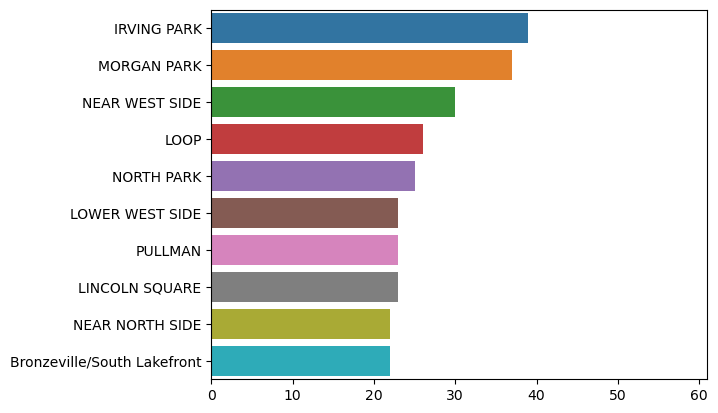

In [8]:
num_programs_array = np.array(num_programs_list)

#Find the 10 clusters with the most programs
top_indices = np.argsort(-num_programs_array)[:10]

#Graph the 10 clusters with the most programs
sns.barplot(data = data.reset_index(), y = clusters[top_indices], x = num_programs_array[top_indices].tolist())
plt.xlim(0, 61)

AxesSubplot(0.125,0.11;0.775x0.77)


(0.0, 61.0)

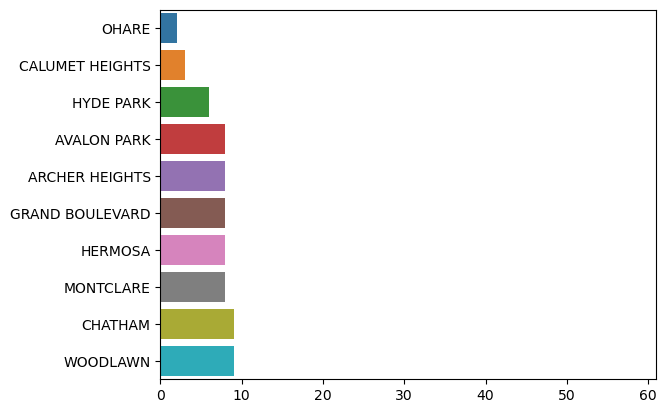

In [9]:
#Find the 10 clusters with the fewest programs
bottom_indices = np.argsort(num_programs_array)[:11]

#Graph the 10 clusters with the fewest programs
print(sns.barplot(data = data, y = clusters[bottom_indices], x = num_programs_array[bottom_indices]))
plt.xlim(0, 61)

In [10]:
# Category Name (we want to make the categories more broad)
# get rid of Category duplicates 
clean_data=clean_data.replace({'Building & Fixing Things': 'Building and Fixing Things',
                                           'Computers.': 'Computers',
                                           'Science ': 'Science & Math',
                                           'Math': 'Science & Math',
                                           'Helping Your Community.': 'Helping Your Community',
                                           'Food.': 'Food'})
unique_categories = clean_data['Category Name'].unique()
unique_categories = pd.Series(unique_categories).drop_duplicates().tolist()
print(unique_categories)

category_counts = clean_data['Category Name'].value_counts()
category_percentages = category_counts / len(clean_data) * 100
print(category_percentages)

['Academic Support', 'Work + Career ', 'Music & Art.', 'Managing Money.', 'Helping Your Community', 'Computers', 'Science & Math', 'Building And Fixing Things', 'Food', 'Sports + Wellness.', 'Building and Fixing Things', 'Reading & Writing.', 'Performance.', 'Digital Media.', 'Nature.', 'Healthcare', 'Transportation', 'Social Studies ', 'Teaching', 'Customer/Human Service', 'Law', nan]
Sports + Wellness.            51.168937
Music & Art.                  23.643017
Reading & Writing.            11.299414
Academic Support               3.962372
Science & Math                 2.031085
Building and Fixing Things     1.339888
Computers                      1.204975
Helping Your Community         0.890795
Nature.                        0.883402
Food                           0.872313
Healthcare                     0.809477
Performance.                   0.717071
Work + Career                  0.569221
Digital Media.                 0.334510
Managing Money.                0.085014
Social Stud

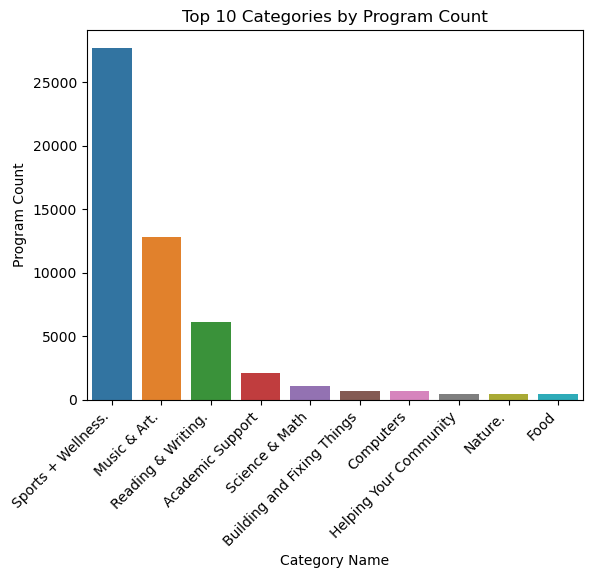

In [11]:
# Calculate the number of programs in each category
category_counts = clean_data['Category Name'].value_counts()

# Select the top 10 categories by program count
top_categories = category_counts[:10]

# Create a bar plot of the top 10 categories
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category Name')
plt.ylabel('Program Count')
plt.title('Top 10 Categories by Program Count')
plt.show()

In [12]:
# Read in the Chicago community area shapefile
url = 'https://data.cityofchicago.org/api/geospatial/cauq-8yn6?method=export&format=GeoJSON'
with urllib.request.urlopen(url) as url:
    data = json.loads(url.read().decode())
chicago = gpd.GeoDataFrame.from_features(data, crs='EPSG:4326')

# Create a DataFrame with the count of unique program names in each geographic cluster
total_programs = clean_data['Program Name'].nunique()
program_counts = (clean_data.groupby('Geographic Cluster Name')['Program Name']
                  .nunique()
                  .reset_index(name='count')
                  .assign(percentage=lambda x: (x['count'] / total_programs) * 100))

# Merge program_counts with chicago
merged = chicago.merge(program_counts, left_on='community', right_on='Geographic Cluster Name')

# Create a choropleth map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
folium.Choropleth(
    geo_data=merged.to_json(),
    name='choropleth',
    data=merged,
    columns=['community', 'percentage'],
    key_on='feature.properties.community',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of Programs'
).add_to(m)

folium.LayerControl().add_to(m)

m.save('map.html')